# Investigation the artifact effect of Tor's note

In this document, we try to understand that why profile B in Tor's note do not feel exhibite boundary artifact. For EM scheme, We will use the function : $$f(Z, dt):==\frac{-(Z + Drift(Z)dt)}{Diffu(Z)}=dW $$ to find the maxmium dW to reach the boundary for Z near the boundary. And then, we will compare the probability density function of dW ~ N(0, dt) to see how like get the maximum dW or less (Remember that dW is negative).

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

## Diffusivity profile

## Lgrangian schemes

In [2]:
#######
#Euler#
#######
def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

########
#Visser#
########
def step_v(z,H,dt,N_sample):
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    a=dKdz(z)
    G=Diffu(z+a*dt/2)
    
    temp= z + a*dt + np.sqrt(2/r*dt*G)*dW
    return temp

def step_v_const(z,H,dt,N_sample):
    K0=3e-3
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    temp= z + np.sqrt(2/r*dt*K0)*dW
    return temp

##############
#Milstein 1nd#
##############
def step_m(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z + (1/2)*dKdz(z)*(dW*dW+dt) + Beta(z)*dW
    return temp

##############
#Milstein 2nd#
##############
def step_m2(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=dAdz(z)
    dddkdz=ddAdzz(z)
    sqrt2k=np.sqrt(2*k)
    
    a=dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
    
    return temp

def step_m2_const(z,H,dt,N_sample):
    K0=3e-3
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z +np.sqrt(2*K0)*dW
    return temp

## Now, we test the diffusivity of $K_0 = 0.001$

In [3]:
import sympy
z = sympy.symbols('z')
K0 = 0
K1 = 5e-3# m / s
Aalpha = 0.5
w=0
sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)
Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta, np)

In [4]:
def oneStep1(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel1(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')

    z = np.random.uniform(0 , H, int(Np))

    for i in range(Ntime):

        z, Cross, Land = oneStep1( z,    scheme,         H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins = np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0
        
        temp2, _ = np.histogram(Cross, bins = np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2
        
        temp3, _ = np.histogram(Land, bins = np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3 

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    
    return None
        
def RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel1, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

    hist_  = hist_  / counter
    hist_  = hist_  / (np.mean(hist_)) # Choose the sum is 2.
    
    hist_Cross = hist_Cross / (np.sum(hist_Cross)*(midpoints[1]-midpoints[0]))
    hist_Land = hist_Land / (np.sum(hist_Land)*(midpoints[1]-midpoints[0]))
    
    return hist_, hist_Cross, hist_Land

In [5]:
Np        = 20000
Nbins     = 100
Tmax      = 10*3600          #Maximum time
dt        = 10            #Delta time
H         = 10
Testdepth = 1
NumberOfThread = 4

startTime=time()
lists = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins)
endTime=time()
print("Time elapsed: ", endTime-startTime)

hist_E      = lists[0]
hist_V      = lists[1]
hist_M      = lists[2]
hist_M2     = lists[3]
hist_EConst = lists[4]
hist_VConst = lists[5]
hist_MConst = lists[6]

NameError: name 'RunSimulation' is not defined

The f(0) is :  -0.28845838329755696


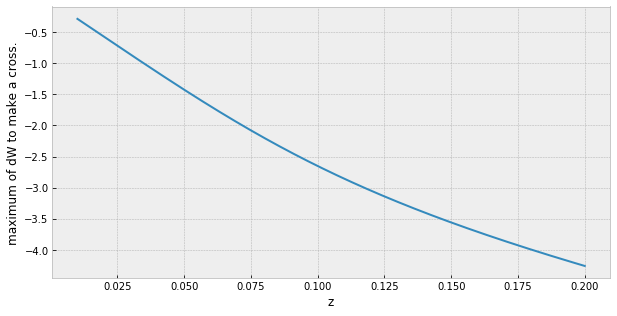

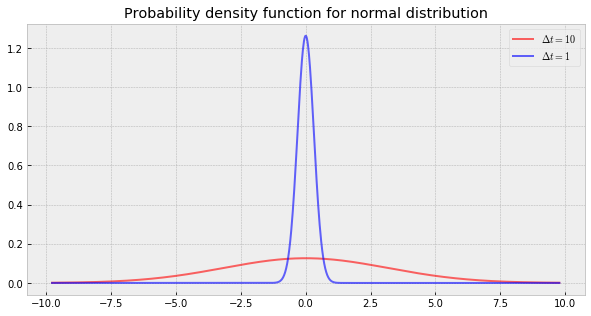

In [60]:
# For Euler scheme.
z = np.linspace(1e-2, 0.2, 10000)
A = Alpha(z)*dt
B = Beta(z)
f = -(z + A)/B

plt.figure(1, figsize = (10, 5))
plt.plot(z, -(z + A)/B)
plt.xlabel("z")
plt.ylabel("maximum of dW to make a cross.")

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
x = np.linspace(norm.ppf(0.001, 0, np.sqrt(10)), norm.ppf(0.999, 0, np.sqrt(10)), 1000)

ax.plot(x, norm.pdf(x, 0 , np.sqrt(10)),
       'r-', lw=2, alpha=0.6, label='$\Delta t =10$')
ax.plot(x, norm.pdf(x, 0 , np.sqrt(0.1)),
       'b-', lw=2, alpha=0.6, label='$\Delta t =1$')
ax.set_title("Probability density function for normal distribution")
ax.legend()
print("The f(0) is : ", f[0])

0.48940150222928097


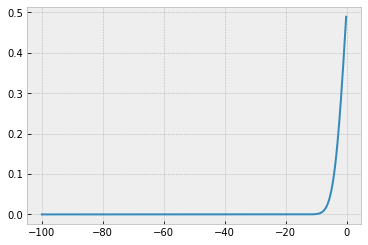

In [20]:
x = np.linspace(-100, -0.134, 1000)
D = norm.pdf(x, 0 , np.sqrt(10))
C = np.cumsum(D)*(x[1]-x[0])
print(C[-1])
plt.plot(x,C)

# To verify the idea. We try to do the statistic sampling of position of the particle that have chance to utilise the reflection algorithm.

In [25]:
import sympy
z = sympy.symbols('z')
dt = sympy.symbols('dt')
K0 = 1e-3
K1 = 6e-3# m / s
Aalpha = 0.5
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)
sym_F = -(z + sym_Alpha*dt)/sym_Beta
sym_dFdz = sympy.diff(sym_F, z, 1)
sym_F_const = -(z)/sympy.sqrt(2*3e-3)
sym_dFdz_const = sympy.diff(sym_F_const, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)
F = sympy.utilities.lambdify([z, dt], sym_F,np)
dFdz = sympy.utilities.lambdify([z, dt], sym_dFdz,np)
F_const = sympy.utilities.lambdify([z, dt], sym_F_const,np)
dFdz_const = sympy.utilities.lambdify([z, dt], sym_dFdz_const,np)
del z, dt

#######
#Euler#
#######
def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

6695.182327573072
0.001
0.1341640786499874


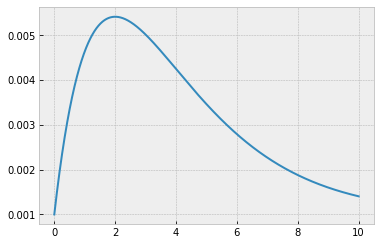

In [26]:
z = np.linspace(0, 10, 2000)
plt.plot(z,Diffu(z))
print(1/np.max(dAdz(z)))
print(Diffu(0))
print(Alpha(0)/Beta(0))

In [23]:
def oneStep1(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel1(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')

    z = np.random.uniform(0 , H, int(Np))

    for i in range(Ntime):

        z, Cross, Land = oneStep1( z,    scheme,         H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins = np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0
        
        temp2, _ = np.histogram(Cross, bins = np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2
        
        temp3, _ = np.histogram(Land, bins = np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3 

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    
    return None
        
def RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel1, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

    hist_  = hist_  / counter
    hist_  = hist_  / (np.mean(hist_)) # Choose the sum is 2.
    
    hist_Cross = hist_Cross / (np.sum(hist_Cross)*(midpoints[1]-midpoints[0]))
    hist_Land = hist_Land / (np.sum(hist_Land)*(midpoints[1]-midpoints[0]))
    
    return hist_, hist_Cross, hist_Land

In [30]:
Np        = 240000
Nbins     = 200
dt        = 10
Tmax = dt*1*3600
H         = 10
Testdepth = 0.7
NumberOfThread = 4

startTime=time()
E1, E1_Cross, E1_Land = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)
endTime=time()
print("Time elapsed: ", endTime-startTime)

startTime=time()
E1_Const, E1_Const_Cross, E1_Const_Land = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_const)
endTime=time()
print("Time elapsed: ", endTime-startTime)

Total number of process:  4
Time elapsed:  52.50870943069458
Total number of process:  4
Time elapsed:  36.79806351661682


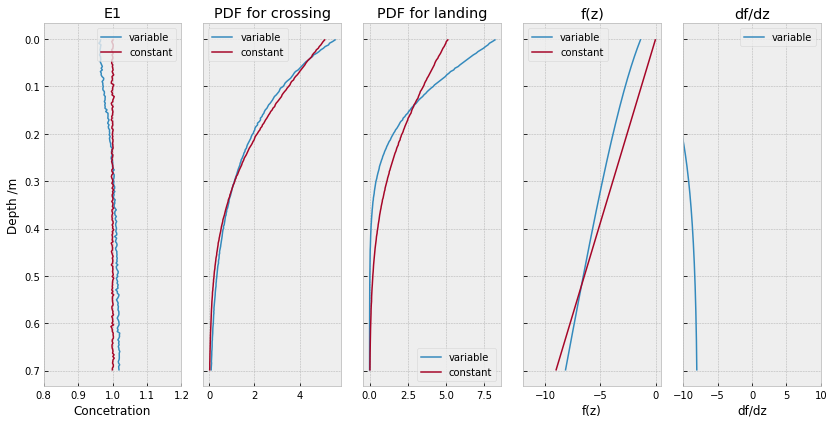

In [31]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 5, figsize = (11.69,6), sharey = True)
ax[0].plot(E1, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_Const, midpoints, linewidth=1.5, label= "constant")
#ax[0].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].set_xlim(0.8, 1.2)
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(E1_Cross, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(E1_Const_Cross, midpoints, linewidth=1.5, label= "constant")
#ax[1].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[1].set_xlabel("")
ax[1].set_title("PDF for crossing")
ax[1].legend()

ax[2].plot(E1_Land, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_Const_Land, midpoints, linewidth=1.5, label= "constant")
#ax[2].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[2].set_xlabel("")
ax[2].set_title("PDF for landing")
ax[2].legend()

ax[3].plot(F(midpoints,dt), midpoints, linewidth=1.5, label= "variable")
ax[3].plot(F_const(midpoints,dt), midpoints, linewidth=1.5, label= "constant")
#ax[3].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[3].set_xlabel("f(z)")
ax[3].set_title("f(z)")
ax[3].set_xlim(-12, 0.5)
ax[3].legend()

ax[4].plot(dFdz(midpoints,dt), midpoints, linewidth=1.5, label= "variable")
#ax[4].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[4].set_xlabel('df/dz')
ax[4].set_title("df/dz")
ax[4].set_xlim(-10, 10)
ax[4].legend()

plt.tight_layout()

In [48]:
import sympy
z = sympy.symbols('z')
dt = sympy.symbols('dt')
K0 = 1e-6
K1 = 6e-3# m / s
Aalpha = 0.5
w=0
c=10

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z) + K1/c*(1-sympy.tanh(c*z))
#sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)
sym_F = -(z + sym_Alpha*dt)/sym_Beta
sym_dFdz = sympy.diff(sym_F, z, 1)
sym_F_const = -(z)/sympy.sqrt(2*3e-3)
sym_dFdz_const = sympy.diff(sym_F_const, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)
F = sympy.utilities.lambdify([z, dt], sym_F,np)
dFdz = sympy.utilities.lambdify([z, dt], sym_dFdz,np)
F_const = sympy.utilities.lambdify([z, dt], sym_F_const,np)
dFdz_const = sympy.utilities.lambdify([z, dt], sym_dFdz_const,np)
del z, dt

#######
#Euler#
#######
def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

0.0
24.704532224573786
0.000601


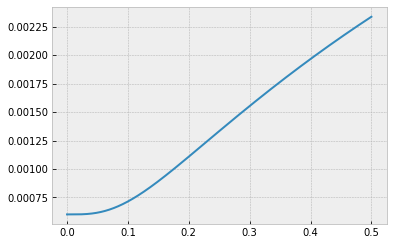

In [49]:
z = np.linspace(0, 0.5, 2000)
plt.plot(z,Diffu(z))
print(Alpha(0))
print(1/np.max(dAdz(z)))
print(Diffu(0))

In [66]:
Np        = 240000
Nbins     = 200
dt        = 0.1
Tmax = dt*1*3600
H         = 10
Testdepth = 2
NumberOfThread = 4

startTime=time()
E1, E1_Cross, E1_Land = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)
endTime=time()
print("Time elapsed: ", endTime-startTime)

startTime=time()
E1_Const, E1_Const_Cross, E1_Const_Land = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_const)
endTime=time()
print("Time elapsed: ", endTime-startTime)

Total number of process:  4
Time elapsed:  61.65176486968994
Total number of process:  4
Time elapsed:  37.657910108566284


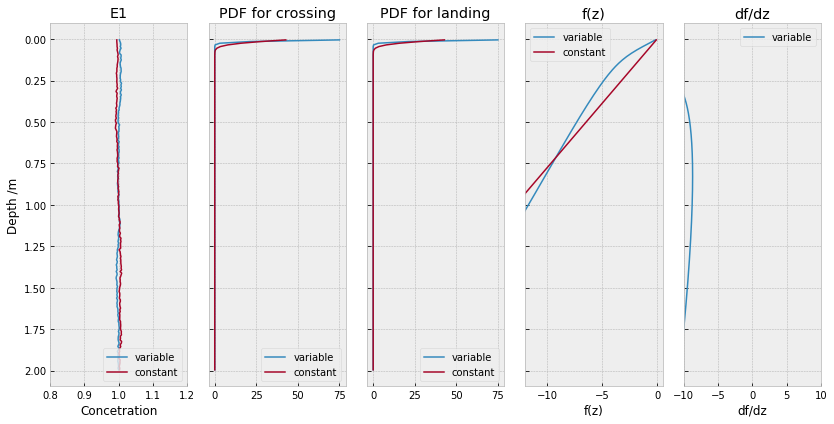

In [67]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 5, figsize = (11.69,6), sharey = True)
ax[0].plot(E1, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_Const, midpoints, linewidth=1.5, label= "constant")
#ax[0].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].set_xlim(0.8, 1.2)
ax[0].invert_yaxis()
ax[0].legend(loc=4)

ax[1].plot(E1_Cross, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(E1_Const_Cross, midpoints, linewidth=1.5, label= "constant")
#ax[1].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[1].set_xlabel("")
ax[1].set_title("PDF for crossing")
ax[1].legend()

ax[2].plot(E1_Land, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_Const_Land, midpoints, linewidth=1.5, label= "constant")
#ax[2].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[2].set_xlabel("")
ax[2].set_title("PDF for landing")
ax[2].legend()

ax[3].plot(F(midpoints,dt), midpoints, linewidth=1.5, label= "variable")
ax[3].plot(F_const(midpoints,dt), midpoints, linewidth=1.5, label= "constant")
#ax[3].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[3].set_xlabel("f(z)")
ax[3].set_title("f(z)")
ax[3].set_xlim(-12, 0.5)
ax[3].legend()

ax[4].plot(dFdz(midpoints,dt), midpoints, linewidth=1.5, label= "variable")
#ax[4].axhline(0.05959, color="g", lw=2, alpha = 0.5)
ax[4].set_xlabel('df/dz')
ax[4].set_title("df/dz")
ax[4].set_xlim(-10, 10)
ax[4].legend()

plt.tight_layout()

In [45]:
import sympy
z = sympy.symbols('z')
dt = sympy.symbols('dt')
K0 = 1e-6
K1 = 6e-3# m / s
Aalpha = 0.5
w=0
c=10

sym_DiffSmooth =  K0 + K1 * z * sympy.exp(-Aalpha * z) + K1/c*(1-sympy.tanh(c*z))
DiffuSmooth  =  sympy.utilities.lambdify(z,          sym_DiffSmooth,np)
sym_D2_Smooth = sympy.diff(sym_DiffSmooth, z, 1)
D2_Smooth  =  sympy.utilities.lambdify(z,          sym_D2_Smooth,np)

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
sym_D2 = sympy.diff(sym_Diffu, z, 1)
D2  =  sympy.utilities.lambdify(z,          sym_D2,np)

del z, dt

0.0


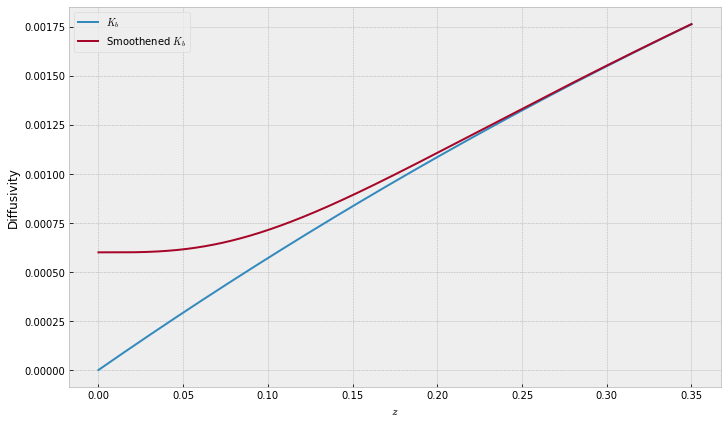

In [46]:
x = np.linspace(0, 0.35, 1000)
fig = plt.figure(figsize=(11.69,7))
plt.plot(x, Diffu(x), label = "$K_b$" )
plt.plot(x, DiffuSmooth(x), label = "Smoothened $K_b$")
plt.ylabel("Diffusivity")
plt.xlabel("$z$")
plt.legend()
print(D2_Smooth(0))

In [167]:
dFdz(0.05959,dt)

-0.010079551356781735

In [140]:
np.sum(E1_Const_Cross)*(midpoints[1]-midpoints[0])

0.9999999999999998

In [12]:
F(0, 10)

-0.4242640687119285

In [132]:
norm.ppf(0.341, 0, np.sqrt(dt))

-1.295697355998348

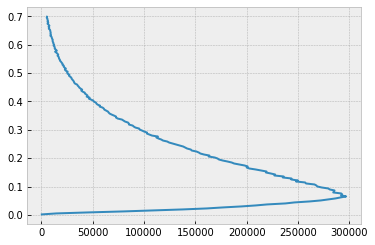

In [304]:
z = np.random.choice(E1_Cross.size, 20000000, p=np.ndarray.tolist(E1_Cross/np.sum(E1_Cross)))
temp, _ = np.histogram(midpoints[z], bins = np.linspace(0, 0.7, 200))
plt.plot(temp, midpoints)


In [275]:
np.random.choice(5, 3, p=[0.1, 0, 0.3, 0.6, 0])

array([0, 2, 2])